In [36]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import lightgbm as lgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
data=pd.read_csv('./datasets/train_set.csv')
data['label'].value_counts()

label
0    244912
1     15952
Name: count, dtype: int64

In [5]:
zd=data[data['label']==0].sample(n=20000)
od=data[data['label']==1]
data=pd.concat([zd,od],axis=0).reset_index(drop=True)
data['label'].value_counts()

label
0    20000
1    15952
Name: count, dtype: int64

In [34]:
Y=data['label'].__array__()
X=data.drop('label',axis=1).__array__()
train_x,test_x,train_y,test_y=train_test_split(X,Y,test_size=0.3)
train_x.shape,test_x.shape

((182604, 10), (78260, 10))

In [28]:
def plot_roc(y_test, y_score):
    fpr,tpr,threshold = skm.roc_curve(y_test, y_score)
    roc_auc = skm.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color='black', lw = 1)
    plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
    plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()

## LightGBM

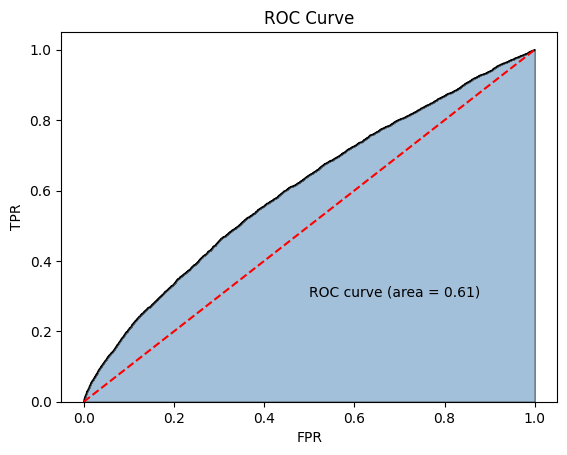

In [35]:
train_set_gbm=lgb.Dataset(train_x,label=train_y)

params={
    'learning_rate': 0.02,
    'num_leaves': 1024,  # 叶子节点数
    'metric': {'binary_logloss', 'auc'},  # 评估函数
    'objective': 'binary',  # 目标函数
    'boosting': 'dart',   #  rf:随机森林  dart:带dropout 的gbdt
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'min_data_in_leaf': 20,
    'lambda_l2': 0.001,
    "verbosity": -1,
    'is_unbalance':True,
}
gbm = lgb.train(params, train_set_gbm, num_boost_round=500)
# 预测数据集
y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration)

plot_roc(test_y,y_pred)

### MLP方法

In [65]:
class MLP(nn.Module):
    """docstring for MLP."""
    def __init__(self,input_dim):
        super(MLP, self).__init__()
        self.mlp=nn.Sequential(
            nn.Linear(input_dim,128),nn.LeakyReLU(),
            nn.Linear(128,256),nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(),
            nn.Linear(256,128),nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.Linear(128,64),nn.LeakyReLU(),
            nn.Linear(64,1),nn.Sigmoid()
        )
    
    def forward(self,X):
        for l in self.mlp:
            X=l(X)
        return X

class sets(Dataset):
    """docstring for dataset_."""
    def __init__(self, x,y):
        super(sets, self).__init__()
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
    
    def __getitem__(self, index):
        return {'x':self.x[index],'y':self.y[index]}
    def __len__(self,):
        return len(self.x)
    
train_set_mlp=sets(train_x,train_y)
test_set_mlp=sets(test_x,test_y)

train_dl=DataLoader(train_set_mlp,batch_size=128)
test_dl=DataLoader(test_set_mlp,batch_size=128)

model=MLP(10).cuda()

optimizer=optim.Adam(model.parameters(),lr=5e-5)
lossfuc=nn.BCELoss()
epoch=50

model.train()
for e in range(0,epoch):
    for step ,b in enumerate(train_dl):
        pred=model(b['x'].cuda())
        loss=lossfuc(pred.view(-1),b['y'].cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:',e," loss:",loss.item())
    

epoch: 0  loss: 0.15244075655937195
epoch: 1  loss: 0.13690808415412903
epoch: 2  loss: 0.14215384423732758
epoch: 3  loss: 0.13841356337070465
epoch: 4  loss: 0.13846781849861145
epoch: 5  loss: 0.14355528354644775
epoch: 6  loss: 0.14733201265335083
epoch: 7  loss: 0.1406458616256714
epoch: 8  loss: 0.14108705520629883
epoch: 9  loss: 0.13783957064151764
epoch: 10  loss: 0.1345977485179901
epoch: 11  loss: 0.1323099434375763
epoch: 12  loss: 0.13846904039382935
epoch: 13  loss: 0.13276931643486023
epoch: 14  loss: 0.12993547320365906
epoch: 15  loss: 0.14152787625789642
epoch: 16  loss: 0.13944849371910095
epoch: 17  loss: 0.1322389841079712
epoch: 18  loss: 0.13131047785282135
epoch: 19  loss: 0.14042417705059052
epoch: 20  loss: 0.13996481895446777
epoch: 21  loss: 0.13938495516777039
epoch: 22  loss: 0.14314179122447968
epoch: 23  loss: 0.13163676857948303
epoch: 24  loss: 0.13435359299182892
epoch: 25  loss: 0.13310369849205017
epoch: 26  loss: 0.14302438497543335
epoch: 27  loss

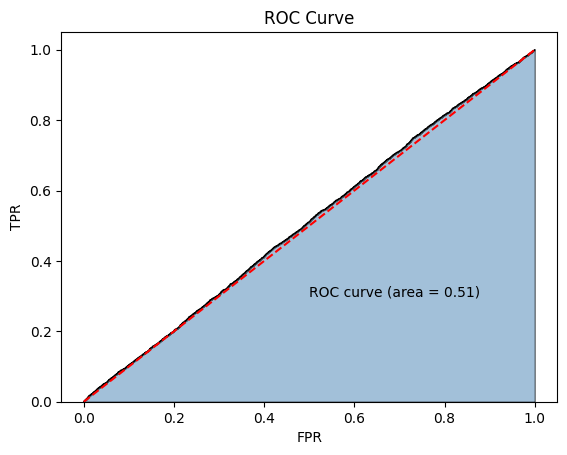

In [66]:
predlist=[]
for step,b in enumerate(test_dl):
    with torch.no_grad():
        predt=model(b['x'].cuda())
        predlist=predlist+predt.view(-1).cpu().numpy().tolist()
#predlist=np.array(predlist).reshape(-1).tolist()
plot_roc(test_y,predlist)